In [3]:
import numpy as np
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt
import torch
from scipy.ndimage import gaussian_filter


In [5]:
# Load data with shape (3, 128, 128) for q_x, q_y, and intensity

# data = np.load('image1.npz')['data']
# data = np.load('images/image_111001.npz')['data']
data = np.load('/Users/cadenmyers/billingelab/dev/skyrmion_lattices/images/image_111019.npz')['data']

# Split into theta and intensity

# computes arctan(q_y/q_x) to get tensor values which are dependent on angle
data_theta = torch.atan2(torch.tensor(data[1]), torch.tensor(data[0]))
data_intensity = torch.tensor(data[2])
print(data.shape)
# plt.imshow(data_theta)
# plt.colorbar()

(3, 128, 128)


In [6]:
def mask_and_blur_images(array):
    '''masks signal inside radius of 14 and outside radius of 30 and adds gaussian blur for all intensity data'''
    for i in range(0,60):
        x,y = np.meshgrid(np.arange(128), np.arange(128))
        radius = np.sqrt((x-64)**2 + (y-62)**2)
        mask1 = radius <= 14
        mask2 = radius >= 30
        masked_data = array[i].copy()
        masked_data[mask1] = 0
        masked_data2 = masked_data.copy()
        masked_data2[mask2] = 0
        # masked_data_norm = (masked_data - np.min(masked_data) / (np.max(masked_data) - np.min(masked_data)))
        blurred_data = gaussian_filter(masked_data2, sigma=.65)
        array[i] = blurred_data
    return array

In [7]:
def project_theta(theta, m_values):
    """
    Project given 2D vectors onto sin(m*theta) and cos(m*theta) for various m values.
    
    Parameters:
    vectors (np.ndarray): Array of shape (N, 2) representing N 2D vectors.
    m_values (list or np.ndarray): Array of m values for projection.
    
    Returns:
    projections (dict): Dictionary with m values as keys and the projected vectors as values.
                        Each projected vector is an array of shape (N, 2).
    """
    projections = []
    
    for m in m_values:
        sin_m_theta = torch.sin(m * theta)
        cos_m_theta = torch.cos(m * theta)
        
        # Form new vectors using the basis functions
        projected_vectors = torch.stack((cos_m_theta, sin_m_theta), axis=-1)
        #print(projected_vectors)
        
        projections.append(projected_vectors)
    
    return torch.stack(projections, axis=0)


In [8]:

def evaluate_functions_on_image(image_shape, coefficients_list, m_values, center):
    """
    Evaluate the functions defined by coefficients for sin(m*theta) and cos(m*theta)
    on an image of a specific shape, centered at a given coordinate.

    Parameters:
    image_shape (tuple): Shape of the image (height, width).
    coefficients_list (list of tuples): List of coefficients for the sin and cos functions [(a_sin, a_cos), ...].
    m_values (list): List of m values for the basis functions.
    center (tuple): The center coordinate (x_center, y_center).

    Returns:
    torch.Tensor: 2D tensor of the evaluated function.
    """
    height, width = image_shape
    x_center, y_center = center

    # Create coordinate grid
    y, x = torch.meshgrid(torch.arange(height) - y_center, torch.arange(width) - x_center, indexing='ij')
    
    # Compute theta for each coordinate
    theta = torch.atan2(y.float(), x.float())
    
    # Initialize the evaluated function image
    evaluated_function = torch.zeros(image_shape, dtype=torch.float32)
    
    # Sum contributions from each m
    for (a_cos, a_sin), m in zip(coefficients_list, m_values):
        evaluated_function += a_sin * torch.sin(m * theta) + a_cos * torch.cos(m * theta)

    #print(evaluated_function)
    return evaluated_function

In [9]:
def evaluate_functions_on_theta(theta, coefficients_list, m_values):
    """
    Evaluate the functions defined by coefficients for sin(m*theta) and cos(m*theta)
    on an image of a specific shape, centered at a given coordinate.

    Parameters:
    image_shape (tuple): Shape of the image (height, width).
    coefficients_list (list of tuples): List of coefficients for the sin and cos functions [(a_sin, a_cos), ...].
    m_values (list): List of m values for the basis functions.
    center (tuple): The center coordinate (x_center, y_center).

    Returns:
    torch.Tensor: 2D tensor of the evaluated function.
    """

    # Initialize the evaluated function image
    evaluated_function = torch.zeros(theta.shape, dtype=torch.float32)
    
    # Sum contributions from each m
    for (a_cos, a_sin), m in zip(coefficients_list, m_values):
        evaluated_function += a_sin * torch.sin(m * theta) + a_cos * torch.cos(m * theta)
        #print(m, a_sin, a_cos)

    #print(evaluated_function)
    return evaluated_function

### Note, I think the columns and rows are showing x vs y respectively (opposite how we normally plot)
#### We can double check this later

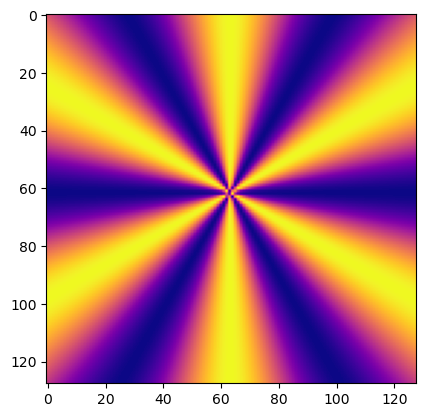

In [122]:
# Example for just cos(6\theta)
evaluate_image_theta = evaluate_functions_on_theta(data_theta, np.array([[1, 0]]), [6])
plt.imshow(evaluate_image_theta.detach(), cmap='plasma', )

tensor([0.0000, 0.3333, 0.6667, 1.0000, 1.3333, 1.6667])
torch.Size([12, 2])


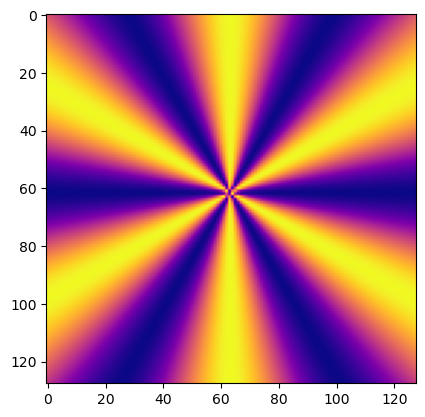

In [10]:
# Set of ms -- reduce for broader angles
ms = torch.arange(12)

# six-fold signal
angles = torch.arange(0, 6) * 2 * torch.pi / 6.
print(angles/np.pi)

# Projection onto circular harmonics (cos(m\theta), sin(m\theta))
projection = project_theta(angles, ms).sum(1)
print(projection.shape)
#plt.plot(data_theta.detach())
#plt.show()
#print(data_theta)
evaluate_image_theta = evaluate_functions_on_theta(data_theta, projection, ms)
plt.imshow(evaluate_image_theta.detach(), cmap='plasma')

## Load data and optimize offset

In [12]:
# Load data
# data = np.load('image1.npz')['data']
# data = np.load('images/image_111001.npz')['data']
data = np.load('/Users/cadenmyers/billingelab/dev/skyrmion_lattices/images/image_111019.npz')['data']

# Split into theta and intensity

# atan2(y, x)
data_theta = torch.atan2(torch.tensor(data[1]), torch.tensor(data[0]))
data_intensity = torch.tensor(data[2])
#print(data[0])
#print(data[1])
print(data_intensity.shape)
#print(data_theta[0])

training_data = np.load('/Users/cadenmyers/billingelab/dev/skyrmion_lattices/current_codes/training_data.npz')
data_intensity = torch.tensor(mask_and_blur_images(training_data['intensity']))
print(data_intensity[0].shape)

torch.Size([128, 128])
torch.Size([128, 128])


In [14]:
#print(training_data['phi'])
phi = training_data['phi'] - 253
print(phi)
# print(offset_list)
#print(offset_list-phi)

[1.473000e-01 1.319000e-01 3.182000e-01 2.134300e+00 5.012900e+00
 6.663700e+00 7.893600e+00 1.050060e+01 1.137660e+01 1.113000e+01
 1.191270e+01 1.435650e+01 1.499780e+01 1.423750e+01 1.479000e+01
 1.455380e+01 1.521210e+01 1.602010e+01 1.886840e+01 2.019830e+01
 2.181760e+01 2.499540e+01 2.661600e+01 3.539740e+01          nan
 3.981100e+01 4.296120e+01 4.508580e+01 5.033400e+01 5.201040e+01
 5.716990e+01 5.779400e+01 5.943920e+01 6.167800e+01 6.170170e+01
 6.554840e+01 6.935380e+01 7.227260e+01 7.715720e+01 7.960270e+01
 7.600830e+01 7.661560e+01 7.648380e+01 7.773430e+01 8.027480e+01
 7.624060e+01 8.058070e+01 8.482580e+01 8.534960e+01 9.577280e+01
 9.793640e+01 1.009562e+02 1.195348e+02 1.223109e+02 1.238100e+02
 1.253879e+02 1.276106e+02 1.288591e+02 1.303689e+02 1.321939e+02]


In [28]:
def optimize_offset(Data_intensity):
    max_iter = 101
    
    offset = torch.tensor(0.)
    offset.requires_grad = True
    opt = torch.optim.Adam([offset], lr=1e-2)
    
    for i in range(max_iter):
        projection = project_theta(angles + offset, ms).sum(1)
        evaluate_image_theta = evaluate_functions_on_theta(data_theta, projection, ms)
        loss = -(Data_intensity * evaluate_image_theta).sum()
        opt.zero_grad()
        loss.backward()
        opt.step()

        #if i % 100 == 0:
        #    print(loss.item(), offset.item())
    return prev_offset + offset.item(), evaluate_image_theta

In [29]:
prev_offset = torch.tensor(0.)
offset_list, evaluate_image_theta_list = [], []
for intensity in data_intensity:
    offset, evaluate_image_theta = optimize_offset(intensity, prev_offset)
    offset_list.append(offset), evaluate_image_theta_list.append(evaluate_image_theta)
    prev_offset = offset
    print(offset)

tensor(0.28)
tensor(0.56)
tensor(0.83)
tensor(1.08)
tensor(1.30)
tensor(1.50)
tensor(1.66)
tensor(1.79)
tensor(1.90)
tensor(1.98)
tensor(2.03)
tensor(2.10)
tensor(2.15)
tensor(2.19)
tensor(2.23)
tensor(2.26)
tensor(2.29)
tensor(2.30)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

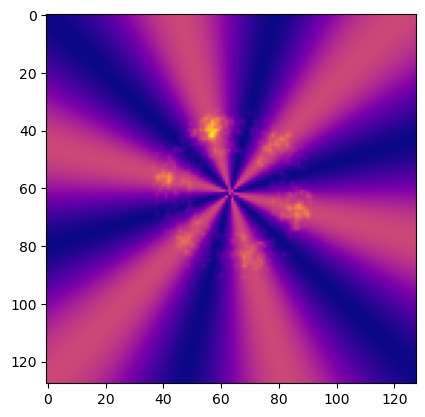

In [17]:
offset, evaluate_image_theta = optimize_offset(data_intensity[0])
plt.imshow((evaluate_image_theta / evaluate_image_theta.abs().max() + data_intensity[0] / data_intensity[0].abs().max()).detach(), cmap='plasma')

In [130]:
print(offset)
print(offset_list)

0.2804715037345886
[tensor(0.2805), tensor(0.2778), tensor(0.2719), tensor(0.2464), tensor(0.2208), tensor(0.1941), tensor(0.1602), tensor(0.1300), tensor(0.1143), tensor(0.0824), tensor(0.0502), tensor(0.0703), tensor(0.0498), tensor(0.0331), tensor(0.0435), tensor(0.0298), tensor(0.0268), tensor(0.0136), tensor(-0.0358), tensor(-0.0608), tensor(-0.1076), tensor(-0.1571), tensor(-0.2131), tensor(-0.2806), tensor(-0.3443), tensor(-0.4403), tensor(-0.5152), tensor(-0.5520), tensor(-0.5980), tensor(-0.6533), tensor(-0.6802), tensor(-0.7208), tensor(-0.7598), tensor(-0.7992), tensor(-0.8054), tensor(-0.8612), tensor(-0.9111), tensor(-0.9588), tensor(-0.9665), tensor(-1.0449), tensor(-1.0608), tensor(-1.0591), tensor(-1.0537), tensor(-1.0454), tensor(-1.0766), tensor(-1.0428), tensor(-1.1057), tensor(-1.1333), tensor(-1.2104), tensor(-1.2537), tensor(-1.2648), tensor(-1.3148), tensor(-1.7063), tensor(-1.8202), tensor(-1.8644), tensor(-1.8821), tensor(-1.8874), tensor(-1.9130), tensor(-1.93

In [148]:
# print(evaluate_image_theta)
# print(evaluate_image_theta_list)

training:  tensor([    0.15,     0.13,     0.32,     2.13,     5.01,     6.66,     7.89,
           10.50,    11.38,    11.13,    11.91,    14.36,    15.00,    14.24,
           14.79,    14.55,    15.21,    16.02,    18.87,    20.20,    21.82,
           25.00,    26.62,    35.40,    37.50,    39.81,    42.96,    45.09,
           50.33,    52.01,    57.17,    57.79,    59.44,    61.68,    61.70,
           65.55,    69.35,    72.27,    77.16,    79.60,    76.01,    76.62,
           76.48,    77.73,    80.27,    76.24,    80.58,    84.83,    85.35,
           95.77,    97.94,   100.96,   119.53,   122.31,   123.81,   125.39,
          127.61,   128.86,   130.37,   132.19], dtype=torch.float64)


RuntimeError: The size of tensor a (18) must match the size of tensor b (60) at non-singleton dimension 0

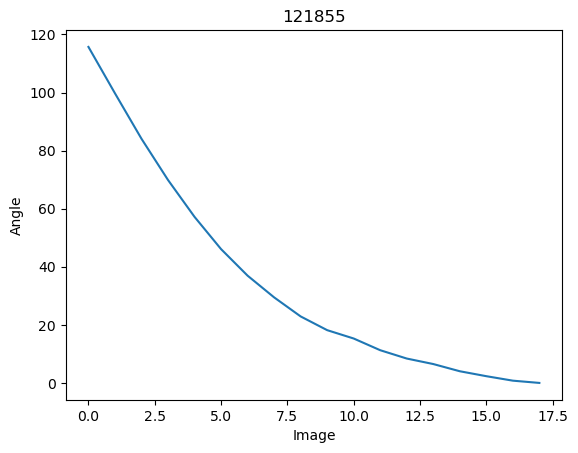

In [30]:
torch.set_printoptions(precision=2, sci_mode=False)
offset_values = torch.tensor(offset_list)
# print(offset_values)

angle_plot = -((offset_values - torch.max(offset_values)) * 180/torch.pi)
# print(angle_plot)
plt.plot(angle_plot)
plt.ylabel("Angle")
plt.xlabel('Image')
plt.title("121855")
print("training: ",phi)
print('diff: ', (angle_plot-phi))
print("max discrepancy: ", torch.max(torch.abs(angle_plot-phi)).item())
guesstimated_value_for_nan = 37.5
phi = torch.tensor(phi)
phi[torch.isnan(phi)] = guesstimated_value_for_nan




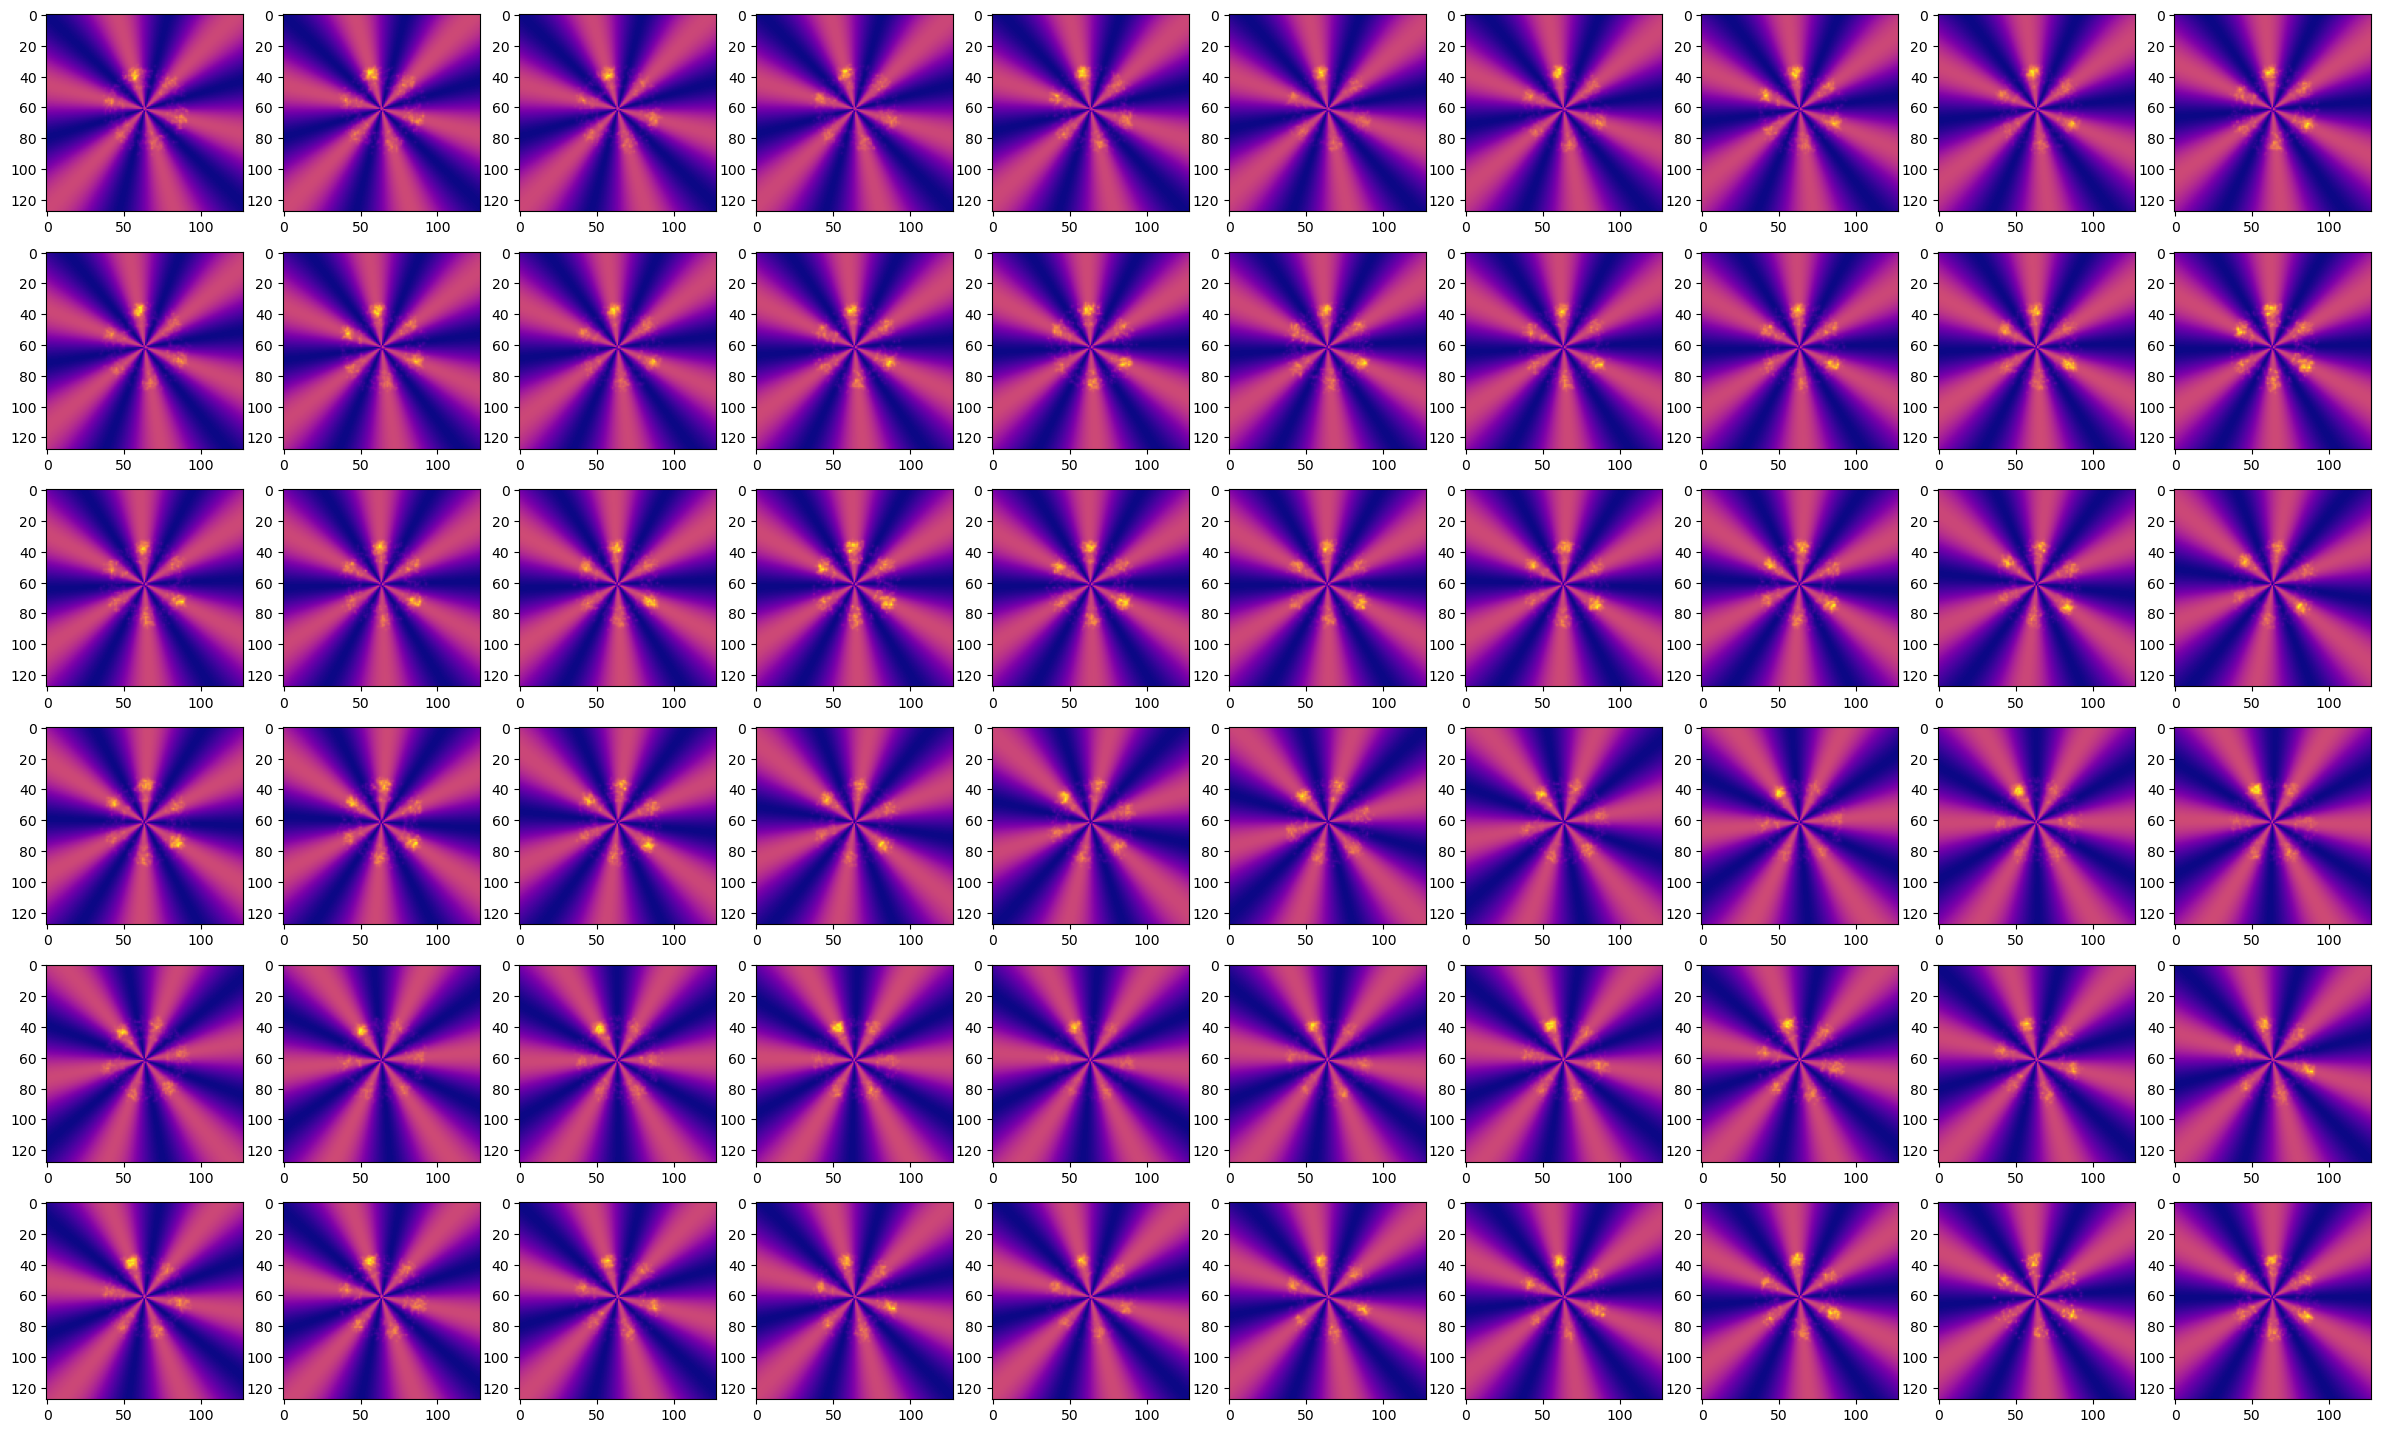

In [133]:
fig, ax = plt.subplots(nrows=6, ncols=10, figsize=(30, 18))
for i in range(6):
    for j in range(10):
        #ax[i, j].imshow(data_intensity[i*6 + j], cmap='plasma')
        #ax[i, j].imshow((evaluate_image_theta / evaluate_image_theta.abs().max() + data_intensity[i*6 + j] / data_intensity[i*6 + j].abs().max()).detach(), cmap='plasma')
        ax[i, j].imshow((evaluate_image_theta_list[i*6 + j] / evaluate_image_theta_list[i*6 + j].abs().max() + data_intensity[i*6 + j] / data_intensity[i*6 + j].abs().max()).detach(), cmap='plasma')



0.2804715037345886


TypeError: Invalid shape (60, 128, 128) for image data

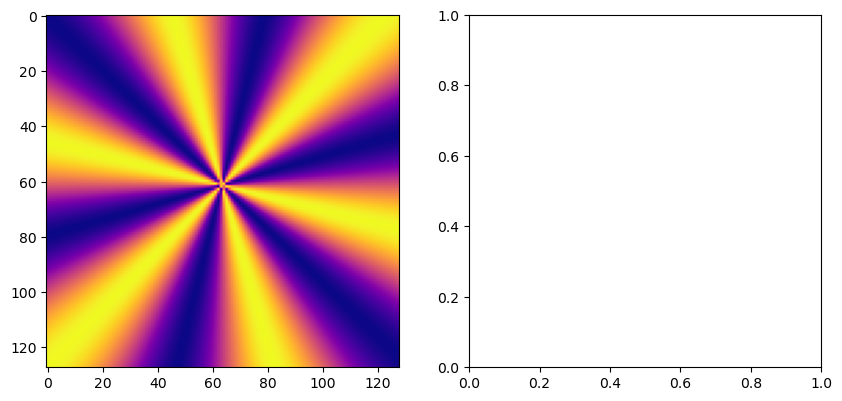

In [134]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
print(offset)
ax[0].imshow(evaluate_image_theta.detach(), cmap='plasma')
ax[1].imshow(data_intensity.detach(), cmap='plasma')

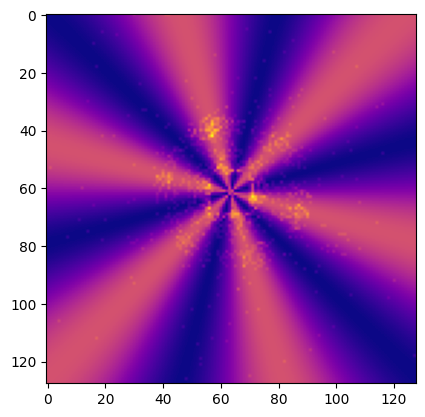

In [ ]:
plt.imshow((evaluate_image_theta / evaluate_image_theta.abs().max() + data_intensity / data_intensity.abs().max()).detach(), cmap='plasma')

In [ ]:
data_intensity.abs().max()

tensor(2778.6777, dtype=torch.float64)

In [ ]:
offset

tensor(0.3979, requires_grad=True)

In [ ]:
# evaluated_image = evaluate_functions_on_image(image_shape, projection, m_values, center)
evaluated_image = evaluate_functions_on_image((128,128), np.array([[1, 0]]), [6], (64,64))

## Zero location roughly

In [ ]:
data[0][64, 64]

0.0010344135816536635

In [ ]:
data[1][64, 64]

0.00031074327217771205

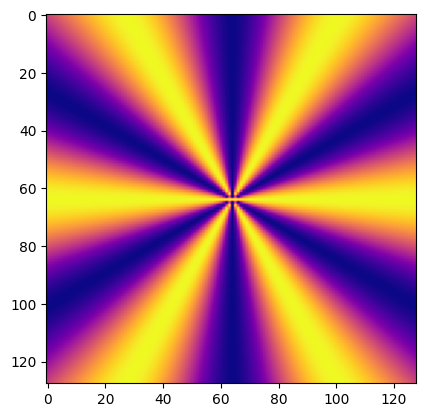

In [ ]:
plt.imshow(evaluated_image, cmap='plasma')